In [9]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [10]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
SENSOR_SIZE = (128, 128, 2)
batch_size = 64

Dataset_path = '../data'
Workers = 8
Targetnum = 11

Test_every_iteration = None
Name_suffix = '_step2_nbEvents_presEvents'
Savemodel_path = './savemodels_DVS/'
Record_path = './recorddata_DVS/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)

_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def convert_to_event_representation(frame_sequence):
    time_steps, channels, height, width = frame_sequence.shape  # (time_steps, 2, 128, 128)
    
    # Check if any event (positive or negative) occurred at each pixel
    event_mask = np.any(frame_sequence > 0, axis=(0, 1)).astype(np.float32)  # (128, 128)
    
    return event_mask


# Set paths
output_dir = "./processed_dvsgesture"
train_data_path = os.path.join(output_dir, "train_data"+Name_suffix+".pkl")
test_data_path = os.path.join(output_dir, "test_data"+Name_suffix+".pkl")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if processed data already exists
if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    # Load processed data
    with open(train_data_path, "rb") as f:
        train_images, train_labels = pickle.load(f)
    with open(test_data_path, "rb") as f:
        test_images, test_labels = pickle.load(f)
    print("Loaded preprocessed data from files")
else:
    # Load dataset
    transform = transforms.Compose([
        transforms.Denoise(filter_time=10000),
        transforms.ToFrame(sensor_size=SENSOR_SIZE, time_window=25000)
    ])

    dataset_train = tonic.datasets.DVSGesture(save_to=Dataset_path, train=True, transform=transform)
    dataset_test = tonic.datasets.DVSGesture(save_to=Dataset_path, train=False, transform=transform)

    # Process training data
    train_images = []
    train_labels = []
    for i, (frames, label) in enumerate(dataset_train):
        if i % 100 == 0:
            print(f"Processing training sample {i}/{len(dataset_train)}")
        img = convert_to_event_representation(frames)
        train_images.append(torch.FloatTensor(img))
        train_labels.append(label)
        
    # Process test data
    test_images = []
    test_labels = []
    for i, (frames, label) in enumerate(dataset_test):
        if i % 100 == 0:
            print(f"Processing test sample {i}/{len(dataset_test)}")
        img = convert_to_event_representation(frames)
        test_images.append(torch.FloatTensor(img))
        test_labels.append(label)

    
    # Save processed data
    with open(train_data_path, "wb") as f:
        pickle.dump((train_images, train_labels), f)
    with open(test_data_path, "wb") as f:
        pickle.dump((test_images, test_labels), f)
    print("Saved preprocessed data to files")


# Create dataloaders
train_data_loader = torch.utils.data.DataLoader(
    list(zip(train_images, train_labels)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=Workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    list(zip(test_images, test_labels)),
    batch_size=batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True
)

Loaded preprocessed data from files



Statistics for Event Mask:

Event Mask:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.1354
  Std: 0.3422


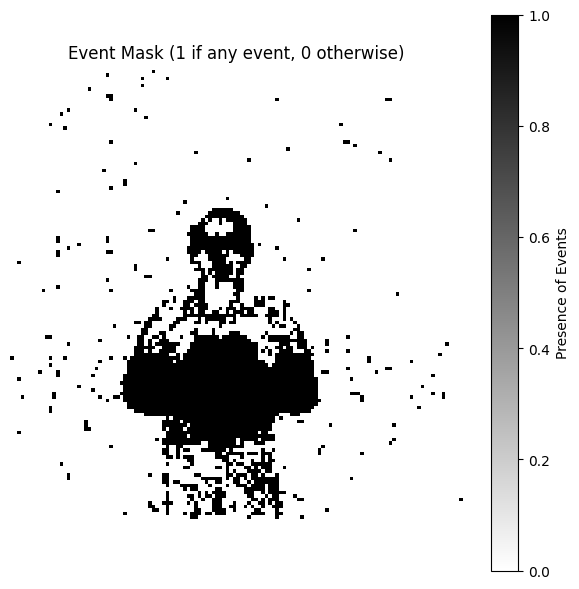

In [12]:
def visualize_event_mask(data_loader, sample_index=0):
    """
    Visualizes the event mask for a sample from the DataLoader, along with statistics.
    
    Args:
        data_loader: PyTorch DataLoader containing (images, labels) pairs.
        sample_index: Index of the sample to visualize within the first batch (default: 0).
    """
    # Get one batch from the DataLoader
    for batch in data_loader:
        images, labels = batch
        break  # Take only the first batch
    
    # Select the sample at sample_index
    if sample_index >= images.shape[0]:
        raise ValueError(f"sample_index {sample_index} is out of range for batch size {images.shape[0]}")
    
    # Extract the event mask (shape: (height, width))
    event_mask = images[sample_index].numpy()  # Convert PyTorch tensor to NumPy array
    
    # Compute statistics
    stats = {
        "Event Mask": {
            "min": np.min(event_mask),
            "max": np.max(event_mask),
            "mean": np.mean(event_mask),
            "std": np.std(event_mask)
        }
    }
    
    # Print statistics
    print("\nStatistics for Event Mask:")
    for channel, values in stats.items():
        print(f"\n{channel}:")
        print(f"  Min: {values['min']:.4f}")
        print(f"  Max: {values['max']:.4f}")
        print(f"  Mean: {values['mean']:.4f}")
        print(f"  Std: {values['std']:.4f}")
    
    # Create figure for visualization
    plt.figure(figsize=(6, 6))
    
    # Plot Event Mask
    plt.imshow(event_mask, cmap='binary')
    plt.title("Event Mask (1 if any event, 0 otherwise)")
    plt.colorbar(label="Presence of Events")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_event_mask(train_data_loader, sample_index=0)

In [13]:
net = Reactnet(num_classes=Targetnum, imagenet=False)

# Modifier la première couche pour accepter 1 canal au lieu de 3
net.feature[0] = firstconv3x3(1, stage_out_channel[0], 1)

In [14]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.

Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [15]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [16]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.unsqueeze(1) 
            img = img.cuda()
            label = label.cuda()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [17]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.unsqueeze(1) 
        img = img.cuda()
        label = label.cuda()
        
        out_fr = net(img)
        loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        loss.backward()

        parameters_list = []
        for name, p in net.named_parameters():
            if not 'fc' in name:
                parameters_list.append(p)
        adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
        optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [18]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=0, train_acc_top1=0.0919, train_acc_top5=0.4708, train_loss=13.6960, test_top1=0.0909, test_top5=0.4545, test_loss=9.5379, max_test_acc=0.0909, total_time=6.7618, LR=0.00100000


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=1, train_acc_top1=0.0845, train_acc_top5=0.4448, train_loss=11.2347, test_top1=0.0909, test_top5=0.4318, test_loss=6.6692, max_test_acc=0.0909, total_time=6.3756, LR=0.00099609


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=2, train_acc_top1=0.0975, train_acc_top5=0.4838, train_loss=6.7071, test_top1=0.0909, test_top5=0.4545, test_loss=6.0881, max_test_acc=0.0909, total_time=6.2378, LR=0.00099219


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=3, train_acc_top1=0.0929, train_acc_top5=0.4475, train_loss=5.4707, test_top1=0.0909, test_top5=0.4545, test_loss=4.8126, max_test_acc=0.0909, total_time=6.2245, LR=0.00098828


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=4, train_acc_top1=0.0929, train_acc_top5=0.4596, train_loss=4.0441, test_top1=0.0909, test_top5=0.4545, test_loss=4.1298, max_test_acc=0.0909, total_time=6.2264, LR=0.00098438


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=5, train_acc_top1=0.0901, train_acc_top5=0.4717, train_loss=4.4573, test_top1=0.0909, test_top5=0.4545, test_loss=4.5482, max_test_acc=0.0909, total_time=6.9880, LR=0.00098047


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=6, train_acc_top1=0.0687, train_acc_top5=0.4113, train_loss=3.3832, test_top1=0.0909, test_top5=0.4545, test_loss=3.9538, max_test_acc=0.0909, total_time=6.2960, LR=0.00097656


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=7, train_acc_top1=0.0891, train_acc_top5=0.4522, train_loss=3.1750, test_top1=0.0909, test_top5=0.4508, test_loss=3.5823, max_test_acc=0.0909, total_time=6.2225, LR=0.00097266


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=8, train_acc_top1=0.0696, train_acc_top5=0.4373, train_loss=3.0276, test_top1=0.0909, test_top5=0.4545, test_loss=3.0099, max_test_acc=0.0909, total_time=6.2540, LR=0.00096875


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=9, train_acc_top1=0.0836, train_acc_top5=0.4401, train_loss=2.9847, test_top1=0.0909, test_top5=0.4659, test_loss=2.7281, max_test_acc=0.0909, total_time=6.2737, LR=0.00096484


100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


epoch=10, train_acc_top1=0.0799, train_acc_top5=0.4345, train_loss=2.9391, test_top1=0.0909, test_top5=0.4545, test_loss=2.9657, max_test_acc=0.0909, total_time=7.0446, LR=0.00096094


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


epoch=11, train_acc_top1=0.0826, train_acc_top5=0.4318, train_loss=2.7733, test_top1=0.0909, test_top5=0.4545, test_loss=3.0802, max_test_acc=0.0909, total_time=6.4521, LR=0.00095703


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=12, train_acc_top1=0.0975, train_acc_top5=0.4559, train_loss=2.6840, test_top1=0.0909, test_top5=0.4545, test_loss=2.7930, max_test_acc=0.0909, total_time=6.2807, LR=0.00095312


100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


epoch=13, train_acc_top1=0.0706, train_acc_top5=0.4475, train_loss=2.7120, test_top1=0.0909, test_top5=0.4545, test_loss=3.0474, max_test_acc=0.0909, total_time=6.3258, LR=0.00094922


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


epoch=14, train_acc_top1=0.0901, train_acc_top5=0.4420, train_loss=2.7703, test_top1=0.0871, test_top5=0.4545, test_loss=2.6148, max_test_acc=0.0909, total_time=6.0448, LR=0.00094531


100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


epoch=15, train_acc_top1=0.0864, train_acc_top5=0.4503, train_loss=2.7453, test_top1=0.0909, test_top5=0.4545, test_loss=2.6563, max_test_acc=0.0909, total_time=6.3450, LR=0.00094141


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=16, train_acc_top1=0.0901, train_acc_top5=0.4475, train_loss=2.6368, test_top1=0.0909, test_top5=0.4470, test_loss=2.5801, max_test_acc=0.0909, total_time=7.2171, LR=0.00093750


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


epoch=17, train_acc_top1=0.0910, train_acc_top5=0.4410, train_loss=2.6219, test_top1=0.0909, test_top5=0.4621, test_loss=2.5436, max_test_acc=0.0909, total_time=6.3163, LR=0.00093359


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=18, train_acc_top1=0.0826, train_acc_top5=0.4225, train_loss=2.5955, test_top1=0.0909, test_top5=0.4735, test_loss=2.5607, max_test_acc=0.0909, total_time=6.3119, LR=0.00092969


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=19, train_acc_top1=0.0864, train_acc_top5=0.4550, train_loss=2.5624, test_top1=0.0909, test_top5=0.4545, test_loss=2.7690, max_test_acc=0.0909, total_time=6.2682, LR=0.00092578


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=20, train_acc_top1=0.0743, train_acc_top5=0.4383, train_loss=2.6417, test_top1=0.0909, test_top5=0.4545, test_loss=2.7320, max_test_acc=0.0909, total_time=6.2653, LR=0.00092188


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=21, train_acc_top1=0.0947, train_acc_top5=0.4708, train_loss=2.5473, test_top1=0.0909, test_top5=0.4545, test_loss=2.5966, max_test_acc=0.0909, total_time=6.2810, LR=0.00091797


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=22, train_acc_top1=0.0808, train_acc_top5=0.4234, train_loss=2.5745, test_top1=0.0909, test_top5=0.4621, test_loss=2.5091, max_test_acc=0.0909, total_time=8.0245, LR=0.00091406


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=23, train_acc_top1=0.0891, train_acc_top5=0.4410, train_loss=2.5106, test_top1=0.0909, test_top5=0.4545, test_loss=2.5158, max_test_acc=0.0909, total_time=6.2318, LR=0.00091016


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


epoch=24, train_acc_top1=0.0919, train_acc_top5=0.4429, train_loss=2.5133, test_top1=0.0909, test_top5=0.4205, test_loss=2.5664, max_test_acc=0.0909, total_time=6.2135, LR=0.00090625


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=25, train_acc_top1=0.0836, train_acc_top5=0.4429, train_loss=2.5533, test_top1=0.0871, test_top5=0.4545, test_loss=2.4529, max_test_acc=0.0909, total_time=5.9356, LR=0.00090234


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=26, train_acc_top1=0.0929, train_acc_top5=0.4401, train_loss=2.4925, test_top1=0.0909, test_top5=0.4545, test_loss=2.4503, max_test_acc=0.0909, total_time=6.2252, LR=0.00089844


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=27, train_acc_top1=0.0919, train_acc_top5=0.4503, train_loss=2.4910, test_top1=0.0909, test_top5=0.4545, test_loss=2.4456, max_test_acc=0.0909, total_time=6.6289, LR=0.00089453


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=28, train_acc_top1=0.0882, train_acc_top5=0.4438, train_loss=2.4953, test_top1=0.0909, test_top5=0.4583, test_loss=2.5057, max_test_acc=0.0909, total_time=6.2191, LR=0.00089063


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=29, train_acc_top1=0.0808, train_acc_top5=0.4373, train_loss=2.4810, test_top1=0.0909, test_top5=0.4697, test_loss=2.4383, max_test_acc=0.0909, total_time=6.2590, LR=0.00088672


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=30, train_acc_top1=0.0836, train_acc_top5=0.4262, train_loss=2.4812, test_top1=0.0909, test_top5=0.4545, test_loss=2.4971, max_test_acc=0.0909, total_time=6.2530, LR=0.00088281


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=31, train_acc_top1=0.0826, train_acc_top5=0.4123, train_loss=2.4755, test_top1=0.0909, test_top5=0.4545, test_loss=2.4430, max_test_acc=0.0909, total_time=6.2607, LR=0.00087891


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=32, train_acc_top1=0.0919, train_acc_top5=0.4568, train_loss=2.4296, test_top1=0.0909, test_top5=0.4583, test_loss=2.4099, max_test_acc=0.0909, total_time=6.2479, LR=0.00087500


100%|██████████| 5/5 [00:00<00:00,  7.11it/s]


epoch=33, train_acc_top1=0.0882, train_acc_top5=0.4318, train_loss=2.4333, test_top1=0.0909, test_top5=0.4545, test_loss=2.4063, max_test_acc=0.0909, total_time=6.8839, LR=0.00087109


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=34, train_acc_top1=0.0761, train_acc_top5=0.4494, train_loss=2.4308, test_top1=0.0909, test_top5=0.4545, test_loss=2.4206, max_test_acc=0.0909, total_time=6.2846, LR=0.00086719


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


epoch=35, train_acc_top1=0.0706, train_acc_top5=0.4215, train_loss=2.4318, test_top1=0.0909, test_top5=0.4508, test_loss=2.4376, max_test_acc=0.0909, total_time=6.3704, LR=0.00086328


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=36, train_acc_top1=0.0910, train_acc_top5=0.4373, train_loss=2.4225, test_top1=0.0909, test_top5=0.4621, test_loss=2.4203, max_test_acc=0.0909, total_time=6.2183, LR=0.00085938


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=37, train_acc_top1=0.0938, train_acc_top5=0.4550, train_loss=2.4112, test_top1=0.1061, test_top5=0.4545, test_loss=2.4015, max_test_acc=0.1061, total_time=6.2206, LR=0.00085547


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


epoch=38, train_acc_top1=0.0891, train_acc_top5=0.4494, train_loss=2.4106, test_top1=0.0909, test_top5=0.4432, test_loss=2.4005, max_test_acc=0.1061, total_time=5.9617, LR=0.00085156


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=39, train_acc_top1=0.0947, train_acc_top5=0.4364, train_loss=2.4089, test_top1=0.0909, test_top5=0.4962, test_loss=2.4010, max_test_acc=0.1061, total_time=6.5453, LR=0.00084766


100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


epoch=40, train_acc_top1=0.0808, train_acc_top5=0.4457, train_loss=2.4064, test_top1=0.0947, test_top5=0.4659, test_loss=2.3871, max_test_acc=0.1061, total_time=5.9880, LR=0.00084375


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=41, train_acc_top1=0.0938, train_acc_top5=0.4652, train_loss=2.4050, test_top1=0.0947, test_top5=0.4621, test_loss=2.4032, max_test_acc=0.1061, total_time=5.9289, LR=0.00083984


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


epoch=42, train_acc_top1=0.1012, train_acc_top5=0.4540, train_loss=2.4135, test_top1=0.0909, test_top5=0.4735, test_loss=2.4237, max_test_acc=0.1061, total_time=5.9306, LR=0.00083594


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=43, train_acc_top1=0.0938, train_acc_top5=0.4578, train_loss=2.4168, test_top1=0.1591, test_top5=0.5076, test_loss=2.3737, max_test_acc=0.1591, total_time=6.3232, LR=0.00083203


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


epoch=44, train_acc_top1=0.1142, train_acc_top5=0.5330, train_loss=2.3816, test_top1=0.1515, test_top5=0.6439, test_loss=2.2909, max_test_acc=0.1591, total_time=5.9940, LR=0.00082812


100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


epoch=45, train_acc_top1=0.1031, train_acc_top5=0.5042, train_loss=2.4469, test_top1=0.1136, test_top5=0.5227, test_loss=2.4006, max_test_acc=0.1591, total_time=6.0609, LR=0.00082422


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=46, train_acc_top1=0.0901, train_acc_top5=0.4698, train_loss=2.4197, test_top1=0.0871, test_top5=0.4811, test_loss=2.4240, max_test_acc=0.1591, total_time=6.0457, LR=0.00082031


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


epoch=47, train_acc_top1=0.1021, train_acc_top5=0.4689, train_loss=2.4305, test_top1=0.0947, test_top5=0.4318, test_loss=2.4404, max_test_acc=0.1591, total_time=5.9174, LR=0.00081641


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=48, train_acc_top1=0.0854, train_acc_top5=0.4188, train_loss=2.4298, test_top1=0.0909, test_top5=0.4697, test_loss=2.4085, max_test_acc=0.1591, total_time=5.9766, LR=0.00081250


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=49, train_acc_top1=0.0743, train_acc_top5=0.4355, train_loss=2.4158, test_top1=0.0909, test_top5=0.4545, test_loss=2.4099, max_test_acc=0.1591, total_time=5.9219, LR=0.00080859


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=50, train_acc_top1=0.0873, train_acc_top5=0.4410, train_loss=2.4125, test_top1=0.0909, test_top5=0.4545, test_loss=2.4027, max_test_acc=0.1591, total_time=5.9763, LR=0.00080469


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=51, train_acc_top1=0.0864, train_acc_top5=0.4420, train_loss=2.4125, test_top1=0.0795, test_top5=0.4621, test_loss=2.4003, max_test_acc=0.1591, total_time=6.0092, LR=0.00080078


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=52, train_acc_top1=0.0929, train_acc_top5=0.4559, train_loss=2.4168, test_top1=0.0909, test_top5=0.4356, test_loss=2.4141, max_test_acc=0.1591, total_time=5.9836, LR=0.00079688


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=53, train_acc_top1=0.0743, train_acc_top5=0.4225, train_loss=2.4137, test_top1=0.1174, test_top5=0.4545, test_loss=2.4053, max_test_acc=0.1591, total_time=5.9081, LR=0.00079297


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=54, train_acc_top1=0.0826, train_acc_top5=0.4336, train_loss=2.4082, test_top1=0.0909, test_top5=0.4053, test_loss=2.4003, max_test_acc=0.1591, total_time=5.9258, LR=0.00078906


100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


epoch=55, train_acc_top1=0.0780, train_acc_top5=0.4373, train_loss=2.4063, test_top1=0.0909, test_top5=0.4545, test_loss=2.4012, max_test_acc=0.1591, total_time=6.1222, LR=0.00078516


100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


epoch=56, train_acc_top1=0.0845, train_acc_top5=0.4373, train_loss=2.4044, test_top1=0.0644, test_top5=0.4545, test_loss=2.4000, max_test_acc=0.1591, total_time=6.0484, LR=0.00078125


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=57, train_acc_top1=0.0854, train_acc_top5=0.4225, train_loss=2.4012, test_top1=0.0909, test_top5=0.5000, test_loss=2.3958, max_test_acc=0.1591, total_time=6.0173, LR=0.00077734


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=58, train_acc_top1=0.0882, train_acc_top5=0.4243, train_loss=2.4037, test_top1=0.1023, test_top5=0.5076, test_loss=2.3968, max_test_acc=0.1591, total_time=5.9741, LR=0.00077344


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=59, train_acc_top1=0.0576, train_acc_top5=0.4448, train_loss=2.4013, test_top1=0.0947, test_top5=0.4545, test_loss=2.3934, max_test_acc=0.1591, total_time=5.9404, LR=0.00076953


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=60, train_acc_top1=0.0873, train_acc_top5=0.4522, train_loss=2.4011, test_top1=0.0909, test_top5=0.4545, test_loss=2.4076, max_test_acc=0.1591, total_time=5.9234, LR=0.00076563


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


epoch=61, train_acc_top1=0.0966, train_acc_top5=0.4568, train_loss=2.4044, test_top1=0.0909, test_top5=0.4545, test_loss=2.4033, max_test_acc=0.1591, total_time=5.9166, LR=0.00076172


100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


epoch=62, train_acc_top1=0.0799, train_acc_top5=0.4299, train_loss=2.4091, test_top1=0.0909, test_top5=0.4394, test_loss=2.3980, max_test_acc=0.1591, total_time=6.0470, LR=0.00075781


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=63, train_acc_top1=0.0901, train_acc_top5=0.4578, train_loss=2.4072, test_top1=0.0909, test_top5=0.4735, test_loss=2.3983, max_test_acc=0.1591, total_time=6.0491, LR=0.00075391


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


epoch=64, train_acc_top1=0.0724, train_acc_top5=0.4169, train_loss=2.4084, test_top1=0.0909, test_top5=0.4470, test_loss=2.3986, max_test_acc=0.1591, total_time=6.0788, LR=0.00075000


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


epoch=65, train_acc_top1=0.0817, train_acc_top5=0.4485, train_loss=2.4029, test_top1=0.0909, test_top5=0.4924, test_loss=2.3952, max_test_acc=0.1591, total_time=6.0640, LR=0.00074609


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


epoch=66, train_acc_top1=0.0882, train_acc_top5=0.4262, train_loss=2.4059, test_top1=0.0909, test_top5=0.4545, test_loss=2.3994, max_test_acc=0.1591, total_time=6.0566, LR=0.00074219


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


epoch=67, train_acc_top1=0.0845, train_acc_top5=0.4178, train_loss=2.4037, test_top1=0.1023, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1591, total_time=6.0512, LR=0.00073828


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


epoch=68, train_acc_top1=0.0771, train_acc_top5=0.4197, train_loss=2.4043, test_top1=0.0909, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1591, total_time=6.0099, LR=0.00073438


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=69, train_acc_top1=0.0836, train_acc_top5=0.4197, train_loss=2.4036, test_top1=0.0909, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1591, total_time=5.9566, LR=0.00073047


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


epoch=70, train_acc_top1=0.0817, train_acc_top5=0.4457, train_loss=2.4014, test_top1=0.1098, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1591, total_time=6.0145, LR=0.00072656


100%|██████████| 5/5 [00:00<00:00,  6.95it/s]


epoch=71, train_acc_top1=0.0808, train_acc_top5=0.4234, train_loss=2.4023, test_top1=0.0909, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1591, total_time=5.9694, LR=0.00072266


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=72, train_acc_top1=0.0864, train_acc_top5=0.4457, train_loss=2.4000, test_top1=0.0909, test_top5=0.4545, test_loss=2.3977, max_test_acc=0.1591, total_time=5.9737, LR=0.00071875


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


epoch=73, train_acc_top1=0.0873, train_acc_top5=0.4197, train_loss=2.3999, test_top1=0.0909, test_top5=0.4924, test_loss=2.3956, max_test_acc=0.1591, total_time=6.0822, LR=0.00071484


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=74, train_acc_top1=0.0910, train_acc_top5=0.4327, train_loss=2.3995, test_top1=0.0909, test_top5=0.4659, test_loss=2.3961, max_test_acc=0.1591, total_time=5.9383, LR=0.00071094


100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


epoch=75, train_acc_top1=0.0966, train_acc_top5=0.4503, train_loss=2.3986, test_top1=0.1326, test_top5=0.5038, test_loss=2.3903, max_test_acc=0.1591, total_time=6.1079, LR=0.00070703


100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


epoch=76, train_acc_top1=0.0975, train_acc_top5=0.4578, train_loss=2.3972, test_top1=0.0909, test_top5=0.4470, test_loss=2.4003, max_test_acc=0.1591, total_time=6.0839, LR=0.00070312


100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


epoch=77, train_acc_top1=0.1021, train_acc_top5=0.4670, train_loss=2.3975, test_top1=0.0909, test_top5=0.4545, test_loss=2.3992, max_test_acc=0.1591, total_time=6.1038, LR=0.00069922


100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


epoch=78, train_acc_top1=0.0808, train_acc_top5=0.4503, train_loss=2.4068, test_top1=0.0909, test_top5=0.4621, test_loss=2.3986, max_test_acc=0.1591, total_time=6.1279, LR=0.00069531


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


epoch=79, train_acc_top1=0.0873, train_acc_top5=0.4327, train_loss=2.4020, test_top1=0.0909, test_top5=0.4659, test_loss=2.3932, max_test_acc=0.1591, total_time=6.1166, LR=0.00069141


100%|██████████| 5/5 [00:00<00:00,  7.11it/s]


epoch=80, train_acc_top1=0.0873, train_acc_top5=0.4680, train_loss=2.3995, test_top1=0.0909, test_top5=0.5720, test_loss=2.3868, max_test_acc=0.1591, total_time=5.9530, LR=0.00068750


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=81, train_acc_top1=0.0966, train_acc_top5=0.4726, train_loss=2.4025, test_top1=0.0909, test_top5=0.4924, test_loss=2.3887, max_test_acc=0.1591, total_time=5.9524, LR=0.00068359


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=82, train_acc_top1=0.0873, train_acc_top5=0.4345, train_loss=2.4250, test_top1=0.0909, test_top5=0.4621, test_loss=2.4053, max_test_acc=0.1591, total_time=5.9479, LR=0.00067969


100%|██████████| 5/5 [00:00<00:00,  6.60it/s]


epoch=83, train_acc_top1=0.0650, train_acc_top5=0.4197, train_loss=2.4090, test_top1=0.0909, test_top5=0.4545, test_loss=2.3992, max_test_acc=0.1591, total_time=6.0204, LR=0.00067578


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=84, train_acc_top1=0.0882, train_acc_top5=0.4206, train_loss=2.4053, test_top1=0.0909, test_top5=0.4621, test_loss=2.3995, max_test_acc=0.1591, total_time=5.9719, LR=0.00067188


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=85, train_acc_top1=0.0854, train_acc_top5=0.4355, train_loss=2.4024, test_top1=0.0909, test_top5=0.4545, test_loss=2.3975, max_test_acc=0.1591, total_time=5.9507, LR=0.00066797


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=86, train_acc_top1=0.0826, train_acc_top5=0.4410, train_loss=2.4066, test_top1=0.0909, test_top5=0.4091, test_loss=2.3987, max_test_acc=0.1591, total_time=6.1254, LR=0.00066406


100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


epoch=87, train_acc_top1=0.0836, train_acc_top5=0.4271, train_loss=2.4016, test_top1=0.0909, test_top5=0.4621, test_loss=2.3982, max_test_acc=0.1591, total_time=6.1851, LR=0.00066016


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=88, train_acc_top1=0.0864, train_acc_top5=0.4290, train_loss=2.4005, test_top1=0.0985, test_top5=0.4886, test_loss=2.3971, max_test_acc=0.1591, total_time=6.0646, LR=0.00065625


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


epoch=89, train_acc_top1=0.0873, train_acc_top5=0.4420, train_loss=2.4000, test_top1=0.0909, test_top5=0.4545, test_loss=2.3968, max_test_acc=0.1591, total_time=6.0115, LR=0.00065234


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=90, train_acc_top1=0.0901, train_acc_top5=0.4429, train_loss=2.3991, test_top1=0.1023, test_top5=0.4811, test_loss=2.3942, max_test_acc=0.1591, total_time=5.9522, LR=0.00064844


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


epoch=91, train_acc_top1=0.0910, train_acc_top5=0.4698, train_loss=2.3982, test_top1=0.1439, test_top5=0.4886, test_loss=2.3932, max_test_acc=0.1591, total_time=5.9703, LR=0.00064453


100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


epoch=92, train_acc_top1=0.1049, train_acc_top5=0.4643, train_loss=2.3978, test_top1=0.1591, test_top5=0.5265, test_loss=2.3765, max_test_acc=0.1591, total_time=6.2840, LR=0.00064063


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=93, train_acc_top1=0.0743, train_acc_top5=0.4308, train_loss=2.4046, test_top1=0.0909, test_top5=0.4621, test_loss=2.3977, max_test_acc=0.1591, total_time=6.3141, LR=0.00063672


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


epoch=94, train_acc_top1=0.0826, train_acc_top5=0.4392, train_loss=2.4035, test_top1=0.0909, test_top5=0.4470, test_loss=2.3972, max_test_acc=0.1591, total_time=6.0759, LR=0.00063281


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=95, train_acc_top1=0.0864, train_acc_top5=0.4299, train_loss=2.4027, test_top1=0.0947, test_top5=0.4545, test_loss=2.3985, max_test_acc=0.1591, total_time=6.0180, LR=0.00062891


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


epoch=96, train_acc_top1=0.0836, train_acc_top5=0.4030, train_loss=2.4085, test_top1=0.0909, test_top5=0.4621, test_loss=2.3994, max_test_acc=0.1591, total_time=6.0295, LR=0.00062500


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=97, train_acc_top1=0.0882, train_acc_top5=0.4234, train_loss=2.4051, test_top1=0.0909, test_top5=0.4886, test_loss=2.4015, max_test_acc=0.1591, total_time=5.9929, LR=0.00062109


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]


epoch=98, train_acc_top1=0.0836, train_acc_top5=0.4206, train_loss=2.4056, test_top1=0.1061, test_top5=0.4545, test_loss=2.3977, max_test_acc=0.1591, total_time=5.9779, LR=0.00061719


100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


epoch=99, train_acc_top1=0.0789, train_acc_top5=0.4466, train_loss=2.4006, test_top1=0.0909, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1591, total_time=5.9843, LR=0.00061328


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=100, train_acc_top1=0.0752, train_acc_top5=0.4178, train_loss=2.4004, test_top1=0.0909, test_top5=0.4508, test_loss=2.3977, max_test_acc=0.1591, total_time=5.9329, LR=0.00060937


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=101, train_acc_top1=0.0724, train_acc_top5=0.4253, train_loss=2.4005, test_top1=0.0985, test_top5=0.4508, test_loss=2.3983, max_test_acc=0.1591, total_time=5.9905, LR=0.00060547


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


epoch=102, train_acc_top1=0.0771, train_acc_top5=0.4262, train_loss=2.4022, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1591, total_time=5.9611, LR=0.00060156


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=103, train_acc_top1=0.0771, train_acc_top5=0.4299, train_loss=2.4003, test_top1=0.0947, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1591, total_time=5.9458, LR=0.00059766


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


epoch=104, train_acc_top1=0.0919, train_acc_top5=0.4345, train_loss=2.4006, test_top1=0.0909, test_top5=0.4545, test_loss=2.3987, max_test_acc=0.1591, total_time=5.9904, LR=0.00059375


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=105, train_acc_top1=0.0808, train_acc_top5=0.4178, train_loss=2.4011, test_top1=0.0909, test_top5=0.4545, test_loss=2.3975, max_test_acc=0.1591, total_time=5.9616, LR=0.00058984


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=106, train_acc_top1=0.0808, train_acc_top5=0.4392, train_loss=2.4007, test_top1=0.0871, test_top5=0.4470, test_loss=2.3977, max_test_acc=0.1591, total_time=5.9656, LR=0.00058594


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=107, train_acc_top1=0.0724, train_acc_top5=0.4225, train_loss=2.4008, test_top1=0.0871, test_top5=0.4470, test_loss=2.3986, max_test_acc=0.1591, total_time=5.9400, LR=0.00058203


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=108, train_acc_top1=0.0771, train_acc_top5=0.4336, train_loss=2.4000, test_top1=0.0909, test_top5=0.4545, test_loss=2.3993, max_test_acc=0.1591, total_time=5.9350, LR=0.00057812


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=109, train_acc_top1=0.0836, train_acc_top5=0.4178, train_loss=2.4005, test_top1=0.0909, test_top5=0.5341, test_loss=2.3968, max_test_acc=0.1591, total_time=5.9806, LR=0.00057422


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=110, train_acc_top1=0.0938, train_acc_top5=0.4633, train_loss=2.3995, test_top1=0.0947, test_top5=0.4697, test_loss=2.3966, max_test_acc=0.1591, total_time=6.0207, LR=0.00057031


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


epoch=111, train_acc_top1=0.0724, train_acc_top5=0.4568, train_loss=2.3996, test_top1=0.0909, test_top5=0.4697, test_loss=2.3983, max_test_acc=0.1591, total_time=6.5363, LR=0.00056641


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


epoch=112, train_acc_top1=0.0734, train_acc_top5=0.4336, train_loss=2.4002, test_top1=0.0985, test_top5=0.5000, test_loss=2.3962, max_test_acc=0.1591, total_time=6.0224, LR=0.00056250


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=113, train_acc_top1=0.0891, train_acc_top5=0.4383, train_loss=2.4003, test_top1=0.0909, test_top5=0.4545, test_loss=2.3968, max_test_acc=0.1591, total_time=6.0048, LR=0.00055859


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


epoch=114, train_acc_top1=0.0761, train_acc_top5=0.4364, train_loss=2.4010, test_top1=0.0909, test_top5=0.4545, test_loss=2.3968, max_test_acc=0.1591, total_time=5.9975, LR=0.00055469


100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


epoch=115, train_acc_top1=0.0864, train_acc_top5=0.4225, train_loss=2.3994, test_top1=0.1288, test_top5=0.4545, test_loss=2.3989, max_test_acc=0.1591, total_time=6.0789, LR=0.00055078


100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


epoch=116, train_acc_top1=0.0873, train_acc_top5=0.4420, train_loss=2.4017, test_top1=0.0909, test_top5=0.4583, test_loss=2.3981, max_test_acc=0.1591, total_time=6.0840, LR=0.00054688


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


epoch=117, train_acc_top1=0.0771, train_acc_top5=0.4188, train_loss=2.4013, test_top1=0.0909, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1591, total_time=6.4131, LR=0.00054297


100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


epoch=118, train_acc_top1=0.0808, train_acc_top5=0.4373, train_loss=2.4002, test_top1=0.1023, test_top5=0.4811, test_loss=2.3979, max_test_acc=0.1591, total_time=6.1917, LR=0.00053906


100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


epoch=119, train_acc_top1=0.0789, train_acc_top5=0.4215, train_loss=2.4003, test_top1=0.0909, test_top5=0.4773, test_loss=2.3981, max_test_acc=0.1591, total_time=6.1783, LR=0.00053516


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


epoch=120, train_acc_top1=0.0836, train_acc_top5=0.4215, train_loss=2.4008, test_top1=0.1023, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1591, total_time=6.1870, LR=0.00053125


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


epoch=121, train_acc_top1=0.0910, train_acc_top5=0.4123, train_loss=2.4016, test_top1=0.0909, test_top5=0.4508, test_loss=2.3984, max_test_acc=0.1591, total_time=6.1703, LR=0.00052734


100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


epoch=122, train_acc_top1=0.0799, train_acc_top5=0.4485, train_loss=2.3988, test_top1=0.0909, test_top5=0.4545, test_loss=2.3982, max_test_acc=0.1591, total_time=6.2272, LR=0.00052344


100%|██████████| 5/5 [00:00<00:00,  6.71it/s]


epoch=123, train_acc_top1=0.0780, train_acc_top5=0.4215, train_loss=2.3995, test_top1=0.0947, test_top5=0.4811, test_loss=2.3980, max_test_acc=0.1591, total_time=6.2097, LR=0.00051953


100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


epoch=124, train_acc_top1=0.0780, train_acc_top5=0.4290, train_loss=2.4008, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1591, total_time=6.1745, LR=0.00051563


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


epoch=125, train_acc_top1=0.0706, train_acc_top5=0.4345, train_loss=2.3993, test_top1=0.0871, test_top5=0.4432, test_loss=2.3980, max_test_acc=0.1591, total_time=6.1583, LR=0.00051172


100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


epoch=126, train_acc_top1=0.0929, train_acc_top5=0.4327, train_loss=2.3995, test_top1=0.0909, test_top5=0.4924, test_loss=2.3964, max_test_acc=0.1591, total_time=6.1964, LR=0.00050781


100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


epoch=127, train_acc_top1=0.0873, train_acc_top5=0.4448, train_loss=2.3989, test_top1=0.1136, test_top5=0.5076, test_loss=2.3964, max_test_acc=0.1591, total_time=6.1486, LR=0.00050391


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


epoch=128, train_acc_top1=0.0761, train_acc_top5=0.4448, train_loss=2.3990, test_top1=0.0644, test_top5=0.4508, test_loss=2.4004, max_test_acc=0.1591, total_time=6.1350, LR=0.00050000


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


epoch=129, train_acc_top1=0.0836, train_acc_top5=0.4234, train_loss=2.4005, test_top1=0.1629, test_top5=0.5189, test_loss=2.3965, max_test_acc=0.1629, total_time=6.5531, LR=0.00049609


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


epoch=130, train_acc_top1=0.0929, train_acc_top5=0.4568, train_loss=2.4006, test_top1=0.0909, test_top5=0.4621, test_loss=2.3976, max_test_acc=0.1629, total_time=6.3883, LR=0.00049219


100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


epoch=131, train_acc_top1=0.0826, train_acc_top5=0.4494, train_loss=2.4009, test_top1=0.0909, test_top5=0.4962, test_loss=2.3982, max_test_acc=0.1629, total_time=6.3793, LR=0.00048828


100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


epoch=132, train_acc_top1=0.0780, train_acc_top5=0.4355, train_loss=2.3996, test_top1=0.0909, test_top5=0.5341, test_loss=2.3968, max_test_acc=0.1629, total_time=6.3062, LR=0.00048437


100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


epoch=133, train_acc_top1=0.0780, train_acc_top5=0.3993, train_loss=2.4021, test_top1=0.0909, test_top5=0.4583, test_loss=2.3969, max_test_acc=0.1629, total_time=6.2862, LR=0.00048047


100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


epoch=134, train_acc_top1=0.0864, train_acc_top5=0.4587, train_loss=2.3979, test_top1=0.0909, test_top5=0.5379, test_loss=2.3942, max_test_acc=0.1629, total_time=6.2117, LR=0.00047656


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


epoch=135, train_acc_top1=0.0743, train_acc_top5=0.4262, train_loss=2.4009, test_top1=0.0947, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1629, total_time=7.2331, LR=0.00047266


100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


epoch=136, train_acc_top1=0.0826, train_acc_top5=0.4308, train_loss=2.4005, test_top1=0.0909, test_top5=0.4545, test_loss=2.4270, max_test_acc=0.1629, total_time=8.1797, LR=0.00046875


100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


epoch=137, train_acc_top1=0.0854, train_acc_top5=0.4188, train_loss=2.4065, test_top1=0.0909, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1629, total_time=8.3857, LR=0.00046484


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=138, train_acc_top1=0.0752, train_acc_top5=0.4494, train_loss=2.4028, test_top1=0.0909, test_top5=0.4394, test_loss=2.3980, max_test_acc=0.1629, total_time=8.2654, LR=0.00046094


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


epoch=139, train_acc_top1=0.0854, train_acc_top5=0.4169, train_loss=2.4076, test_top1=0.0909, test_top5=0.4508, test_loss=2.4011, max_test_acc=0.1629, total_time=8.3735, LR=0.00045703


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


epoch=140, train_acc_top1=0.0836, train_acc_top5=0.4383, train_loss=2.4084, test_top1=0.0909, test_top5=0.4545, test_loss=2.4037, max_test_acc=0.1629, total_time=8.1357, LR=0.00045313


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


epoch=141, train_acc_top1=0.1086, train_acc_top5=0.4373, train_loss=2.4100, test_top1=0.0909, test_top5=0.4545, test_loss=2.4042, max_test_acc=0.1629, total_time=8.2659, LR=0.00044922


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


epoch=142, train_acc_top1=0.0799, train_acc_top5=0.4373, train_loss=2.4117, test_top1=0.0909, test_top5=0.4545, test_loss=2.4023, max_test_acc=0.1629, total_time=8.6927, LR=0.00044531


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=143, train_acc_top1=0.0919, train_acc_top5=0.4448, train_loss=2.4181, test_top1=0.0909, test_top5=0.4583, test_loss=2.4024, max_test_acc=0.1629, total_time=8.0289, LR=0.00044141


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


epoch=144, train_acc_top1=0.0956, train_acc_top5=0.4373, train_loss=2.4124, test_top1=0.0909, test_top5=0.4773, test_loss=2.4259, max_test_acc=0.1629, total_time=8.0908, LR=0.00043750


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


epoch=145, train_acc_top1=0.0817, train_acc_top5=0.4503, train_loss=2.4162, test_top1=0.0909, test_top5=0.4394, test_loss=2.4071, max_test_acc=0.1629, total_time=8.0916, LR=0.00043359


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


epoch=146, train_acc_top1=0.0947, train_acc_top5=0.4401, train_loss=2.4126, test_top1=0.0909, test_top5=0.4545, test_loss=2.4068, max_test_acc=0.1629, total_time=8.2018, LR=0.00042969


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


epoch=147, train_acc_top1=0.0901, train_acc_top5=0.4383, train_loss=2.4155, test_top1=0.0985, test_top5=0.4356, test_loss=2.4004, max_test_acc=0.1629, total_time=8.3323, LR=0.00042578


100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


epoch=148, train_acc_top1=0.0910, train_acc_top5=0.4123, train_loss=2.4215, test_top1=0.0947, test_top5=0.4583, test_loss=2.4002, max_test_acc=0.1629, total_time=7.7990, LR=0.00042187


100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


epoch=149, train_acc_top1=0.0864, train_acc_top5=0.4540, train_loss=2.4111, test_top1=0.0909, test_top5=0.4545, test_loss=2.4040, max_test_acc=0.1629, total_time=7.8496, LR=0.00041797


100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


epoch=150, train_acc_top1=0.0836, train_acc_top5=0.4401, train_loss=2.4104, test_top1=0.0909, test_top5=0.4545, test_loss=2.4288, max_test_acc=0.1629, total_time=8.1296, LR=0.00041406


100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


epoch=151, train_acc_top1=0.0984, train_acc_top5=0.4940, train_loss=2.3988, test_top1=0.1098, test_top5=0.4735, test_loss=2.3789, max_test_acc=0.1629, total_time=8.0177, LR=0.00041016


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


epoch=152, train_acc_top1=0.0873, train_acc_top5=0.4856, train_loss=2.4236, test_top1=0.1288, test_top5=0.4735, test_loss=2.3692, max_test_acc=0.1629, total_time=8.3413, LR=0.00040625


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


epoch=153, train_acc_top1=0.0966, train_acc_top5=0.4930, train_loss=2.3974, test_top1=0.0985, test_top5=0.5644, test_loss=2.3740, max_test_acc=0.1629, total_time=8.1388, LR=0.00040234


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


epoch=154, train_acc_top1=0.1012, train_acc_top5=0.4828, train_loss=2.4678, test_top1=0.1212, test_top5=0.5644, test_loss=2.3491, max_test_acc=0.1629, total_time=8.4730, LR=0.00039844


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


epoch=155, train_acc_top1=0.1031, train_acc_top5=0.4828, train_loss=2.4533, test_top1=0.1136, test_top5=0.5795, test_loss=2.3723, max_test_acc=0.1629, total_time=8.4163, LR=0.00039453


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


epoch=156, train_acc_top1=0.1040, train_acc_top5=0.4819, train_loss=2.4212, test_top1=0.1023, test_top5=0.5000, test_loss=2.3926, max_test_acc=0.1629, total_time=8.3734, LR=0.00039063


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=157, train_acc_top1=0.1244, train_acc_top5=0.5274, train_loss=2.4037, test_top1=0.1667, test_top5=0.5682, test_loss=2.3521, max_test_acc=0.1667, total_time=8.9388, LR=0.00038672


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


epoch=158, train_acc_top1=0.1142, train_acc_top5=0.5153, train_loss=2.4954, test_top1=0.1515, test_top5=0.5114, test_loss=2.4157, max_test_acc=0.1667, total_time=8.8156, LR=0.00038281


100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


epoch=159, train_acc_top1=0.1077, train_acc_top5=0.4884, train_loss=2.4678, test_top1=0.1174, test_top5=0.5000, test_loss=2.4143, max_test_acc=0.1667, total_time=8.5927, LR=0.00037891


100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


epoch=160, train_acc_top1=0.1105, train_acc_top5=0.4800, train_loss=2.4442, test_top1=0.0909, test_top5=0.4356, test_loss=2.4515, max_test_acc=0.1667, total_time=8.2183, LR=0.00037500


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


epoch=161, train_acc_top1=0.0966, train_acc_top5=0.4494, train_loss=2.4407, test_top1=0.1515, test_top5=0.4583, test_loss=2.3973, max_test_acc=0.1667, total_time=7.6618, LR=0.00037109


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


epoch=162, train_acc_top1=0.0891, train_acc_top5=0.5023, train_loss=2.4245, test_top1=0.0909, test_top5=0.4545, test_loss=2.4848, max_test_acc=0.1667, total_time=6.8831, LR=0.00036719


100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


epoch=163, train_acc_top1=0.0808, train_acc_top5=0.4336, train_loss=2.4551, test_top1=0.1098, test_top5=0.5492, test_loss=2.3568, max_test_acc=0.1667, total_time=6.2468, LR=0.00036328


100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


epoch=164, train_acc_top1=0.0994, train_acc_top5=0.4568, train_loss=2.4654, test_top1=0.1098, test_top5=0.4545, test_loss=2.4048, max_test_acc=0.1667, total_time=6.1942, LR=0.00035937


100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


epoch=165, train_acc_top1=0.0873, train_acc_top5=0.4299, train_loss=2.4397, test_top1=0.1023, test_top5=0.4470, test_loss=2.4153, max_test_acc=0.1667, total_time=6.2449, LR=0.00035547


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


epoch=166, train_acc_top1=0.0956, train_acc_top5=0.4540, train_loss=2.4160, test_top1=0.0947, test_top5=0.4583, test_loss=2.4106, max_test_acc=0.1667, total_time=6.2006, LR=0.00035156


100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


epoch=167, train_acc_top1=0.0956, train_acc_top5=0.4373, train_loss=2.4201, test_top1=0.0947, test_top5=0.4811, test_loss=2.4040, max_test_acc=0.1667, total_time=6.1890, LR=0.00034766


100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


epoch=168, train_acc_top1=0.1179, train_acc_top5=0.5144, train_loss=2.3948, test_top1=0.1402, test_top5=0.5758, test_loss=2.3817, max_test_acc=0.1667, total_time=6.1654, LR=0.00034375


100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


epoch=169, train_acc_top1=0.0938, train_acc_top5=0.4977, train_loss=2.4892, test_top1=0.0795, test_top5=0.4545, test_loss=2.5398, max_test_acc=0.1667, total_time=6.1655, LR=0.00033984


100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


epoch=170, train_acc_top1=0.0891, train_acc_top5=0.4773, train_loss=2.4177, test_top1=0.1553, test_top5=0.5606, test_loss=2.3697, max_test_acc=0.1667, total_time=6.1598, LR=0.00033594


100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


epoch=171, train_acc_top1=0.1161, train_acc_top5=0.5432, train_loss=2.3759, test_top1=0.0909, test_top5=0.6023, test_loss=2.3555, max_test_acc=0.1667, total_time=6.1885, LR=0.00033203


100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


epoch=172, train_acc_top1=0.1151, train_acc_top5=0.5961, train_loss=2.3711, test_top1=0.0758, test_top5=0.6402, test_loss=2.3551, max_test_acc=0.1667, total_time=6.1847, LR=0.00032813


100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


epoch=173, train_acc_top1=0.1235, train_acc_top5=0.5887, train_loss=2.3481, test_top1=0.1174, test_top5=0.6212, test_loss=2.3621, max_test_acc=0.1667, total_time=6.1811, LR=0.00032422


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


epoch=174, train_acc_top1=0.1393, train_acc_top5=0.5831, train_loss=2.3557, test_top1=0.1326, test_top5=0.5758, test_loss=2.4687, max_test_acc=0.1667, total_time=6.1798, LR=0.00032031


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


epoch=175, train_acc_top1=0.2145, train_acc_top5=0.7122, train_loss=2.1973, test_top1=0.2462, test_top5=0.7689, test_loss=2.0480, max_test_acc=0.2462, total_time=6.5187, LR=0.00031641


100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


epoch=176, train_acc_top1=0.1903, train_acc_top5=0.6890, train_loss=2.8992, test_top1=0.1364, test_top5=0.5833, test_loss=2.6409, max_test_acc=0.2462, total_time=6.2237, LR=0.00031250


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


epoch=177, train_acc_top1=0.1086, train_acc_top5=0.5534, train_loss=2.5187, test_top1=0.1780, test_top5=0.6061, test_loss=2.2977, max_test_acc=0.2462, total_time=6.7069, LR=0.00030859


100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


epoch=178, train_acc_top1=0.1458, train_acc_top5=0.5664, train_loss=2.5229, test_top1=0.1515, test_top5=0.6288, test_loss=2.3052, max_test_acc=0.2462, total_time=8.1057, LR=0.00030469


100%|██████████| 5/5 [00:01<00:00,  4.29it/s]


epoch=179, train_acc_top1=0.2006, train_acc_top5=0.6880, train_loss=2.2097, test_top1=0.2311, test_top5=0.7727, test_loss=2.0881, max_test_acc=0.2462, total_time=7.8774, LR=0.00030078


100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


epoch=180, train_acc_top1=0.1634, train_acc_top5=0.6323, train_loss=2.6024, test_top1=0.1591, test_top5=0.5568, test_loss=2.3597, max_test_acc=0.2462, total_time=7.9206, LR=0.00029687


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


epoch=181, train_acc_top1=0.1708, train_acc_top5=0.6444, train_loss=2.2954, test_top1=0.1742, test_top5=0.7614, test_loss=2.1225, max_test_acc=0.2462, total_time=8.0340, LR=0.00029297


100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


epoch=182, train_acc_top1=0.2507, train_acc_top5=0.7781, train_loss=2.0668, test_top1=0.1515, test_top5=0.6288, test_loss=2.3018, max_test_acc=0.2462, total_time=7.8560, LR=0.00028906


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


epoch=183, train_acc_top1=0.2507, train_acc_top5=0.7837, train_loss=2.0665, test_top1=0.2348, test_top5=0.8144, test_loss=1.9706, max_test_acc=0.2462, total_time=7.5573, LR=0.00028516


100%|██████████| 5/5 [00:01<00:00,  3.71it/s]


epoch=184, train_acc_top1=0.2646, train_acc_top5=0.8264, train_loss=1.9160, test_top1=0.3371, test_top5=0.9091, test_loss=1.7285, max_test_acc=0.3371, total_time=8.6829, LR=0.00028125


100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


epoch=185, train_acc_top1=0.3454, train_acc_top5=0.8793, train_loss=1.7377, test_top1=0.4205, test_top5=0.9280, test_loss=1.5679, max_test_acc=0.4205, total_time=8.5740, LR=0.00027734


100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


epoch=186, train_acc_top1=0.3231, train_acc_top5=0.8774, train_loss=1.8580, test_top1=0.3030, test_top5=0.9394, test_loss=1.6414, max_test_acc=0.4205, total_time=7.9071, LR=0.00027344


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


epoch=187, train_acc_top1=0.3370, train_acc_top5=0.8784, train_loss=1.7571, test_top1=0.3561, test_top5=0.9697, test_loss=1.5480, max_test_acc=0.4205, total_time=8.1707, LR=0.00026953


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


epoch=188, train_acc_top1=0.3872, train_acc_top5=0.9136, train_loss=1.6503, test_top1=0.4167, test_top5=0.9659, test_loss=1.4348, max_test_acc=0.4205, total_time=8.1473, LR=0.00026563


100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


epoch=189, train_acc_top1=0.3352, train_acc_top5=0.8644, train_loss=1.8604, test_top1=0.4205, test_top5=0.9470, test_loss=1.5052, max_test_acc=0.4205, total_time=7.9718, LR=0.00026172


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


epoch=190, train_acc_top1=0.3779, train_acc_top5=0.9099, train_loss=1.5964, test_top1=0.4356, test_top5=0.9545, test_loss=1.4529, max_test_acc=0.4356, total_time=6.7186, LR=0.00025781


100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


epoch=191, train_acc_top1=0.2507, train_acc_top5=0.7484, train_loss=2.9421, test_top1=0.2235, test_top5=0.8561, test_loss=1.9782, max_test_acc=0.4356, total_time=6.4315, LR=0.00025391


100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


epoch=192, train_acc_top1=0.3370, train_acc_top5=0.8979, train_loss=1.7081, test_top1=0.3182, test_top5=0.9508, test_loss=1.6723, max_test_acc=0.4356, total_time=6.2693, LR=0.00025000


100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


epoch=193, train_acc_top1=0.3417, train_acc_top5=0.8886, train_loss=1.7071, test_top1=0.3977, test_top5=0.9470, test_loss=1.5074, max_test_acc=0.4356, total_time=6.2298, LR=0.00024609


100%|██████████| 5/5 [00:00<00:00,  6.04it/s]


epoch=194, train_acc_top1=0.4253, train_acc_top5=0.9146, train_loss=1.5092, test_top1=0.4432, test_top5=0.9697, test_loss=1.4399, max_test_acc=0.4432, total_time=6.5354, LR=0.00024219


100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


epoch=195, train_acc_top1=0.3714, train_acc_top5=0.9034, train_loss=1.7521, test_top1=0.4773, test_top5=0.9091, test_loss=1.5664, max_test_acc=0.4773, total_time=6.5147, LR=0.00023828


100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


epoch=196, train_acc_top1=0.4782, train_acc_top5=0.9536, train_loss=1.3595, test_top1=0.5833, test_top5=0.9811, test_loss=1.1291, max_test_acc=0.5833, total_time=7.2436, LR=0.00023437


100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


epoch=197, train_acc_top1=0.5330, train_acc_top5=0.9675, train_loss=1.2152, test_top1=0.2992, test_top5=0.8258, test_loss=2.1898, max_test_acc=0.5833, total_time=6.2819, LR=0.00023047


100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


epoch=198, train_acc_top1=0.4949, train_acc_top5=0.9601, train_loss=1.3245, test_top1=0.4848, test_top5=0.9583, test_loss=1.3012, max_test_acc=0.5833, total_time=6.2368, LR=0.00022656


100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


epoch=199, train_acc_top1=0.4930, train_acc_top5=0.9582, train_loss=1.2718, test_top1=0.4432, test_top5=0.9621, test_loss=1.3494, max_test_acc=0.5833, total_time=6.2686, LR=0.00022266


100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


epoch=200, train_acc_top1=0.4652, train_acc_top5=0.9406, train_loss=1.3674, test_top1=0.5644, test_top5=0.9773, test_loss=1.1391, max_test_acc=0.5833, total_time=6.2258, LR=0.00021875


100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


epoch=201, train_acc_top1=0.6156, train_acc_top5=0.9768, train_loss=1.0481, test_top1=0.6174, test_top5=0.9848, test_loss=1.0387, max_test_acc=0.6174, total_time=6.5777, LR=0.00021484


100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


epoch=202, train_acc_top1=0.5190, train_acc_top5=0.8691, train_loss=1.9403, test_top1=0.4318, test_top5=0.8523, test_loss=1.9706, max_test_acc=0.6174, total_time=6.2538, LR=0.00021094


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


epoch=203, train_acc_top1=0.4596, train_acc_top5=0.9285, train_loss=1.4558, test_top1=0.4015, test_top5=0.8864, test_loss=1.5975, max_test_acc=0.6174, total_time=6.3654, LR=0.00020703


100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


epoch=204, train_acc_top1=0.3556, train_acc_top5=0.8505, train_loss=2.1575, test_top1=0.4621, test_top5=0.9432, test_loss=1.4102, max_test_acc=0.6174, total_time=7.2938, LR=0.00020313


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


epoch=205, train_acc_top1=0.5190, train_acc_top5=0.9749, train_loss=1.1526, test_top1=0.6364, test_top5=0.9848, test_loss=1.0075, max_test_acc=0.6364, total_time=8.1579, LR=0.00019922


100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


epoch=206, train_acc_top1=0.6137, train_acc_top5=0.9796, train_loss=1.0044, test_top1=0.5871, test_top5=0.9924, test_loss=1.1035, max_test_acc=0.6364, total_time=8.2284, LR=0.00019531


100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


epoch=207, train_acc_top1=0.5515, train_acc_top5=0.9601, train_loss=1.3051, test_top1=0.6591, test_top5=0.9886, test_loss=0.8985, max_test_acc=0.6591, total_time=8.5994, LR=0.00019141


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


epoch=208, train_acc_top1=0.5079, train_acc_top5=0.9127, train_loss=1.4943, test_top1=0.2083, test_top5=0.7538, test_loss=2.6133, max_test_acc=0.6591, total_time=8.3182, LR=0.00018750


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


epoch=209, train_acc_top1=0.3445, train_acc_top5=0.8422, train_loss=1.9359, test_top1=0.3712, test_top5=0.8939, test_loss=1.7931, max_test_acc=0.6591, total_time=8.4069, LR=0.00018359


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


epoch=210, train_acc_top1=0.4364, train_acc_top5=0.9489, train_loss=1.4268, test_top1=0.5303, test_top5=0.9848, test_loss=1.1062, max_test_acc=0.6591, total_time=8.3344, LR=0.00017969


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


epoch=211, train_acc_top1=0.5432, train_acc_top5=0.9656, train_loss=1.1676, test_top1=0.5682, test_top5=0.9848, test_loss=1.0507, max_test_acc=0.6591, total_time=7.9014, LR=0.00017578


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


epoch=212, train_acc_top1=0.5989, train_acc_top5=0.9833, train_loss=0.9389, test_top1=0.5644, test_top5=0.9811, test_loss=1.0115, max_test_acc=0.6591, total_time=8.0884, LR=0.00017187


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


epoch=213, train_acc_top1=0.6555, train_acc_top5=0.9824, train_loss=0.9230, test_top1=0.5417, test_top5=0.9773, test_loss=1.0226, max_test_acc=0.6591, total_time=8.6173, LR=0.00016797


100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


epoch=214, train_acc_top1=0.5952, train_acc_top5=0.9786, train_loss=0.9853, test_top1=0.4848, test_top5=0.9280, test_loss=1.3690, max_test_acc=0.6591, total_time=7.8780, LR=0.00016406


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


epoch=215, train_acc_top1=0.5747, train_acc_top5=0.9851, train_loss=0.9949, test_top1=0.5871, test_top5=0.9962, test_loss=1.0252, max_test_acc=0.6591, total_time=8.2299, LR=0.00016016


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


epoch=216, train_acc_top1=0.6035, train_acc_top5=0.9842, train_loss=0.8969, test_top1=0.6515, test_top5=0.9886, test_loss=0.9541, max_test_acc=0.6591, total_time=7.6863, LR=0.00015625


100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


epoch=217, train_acc_top1=0.6917, train_acc_top5=0.9889, train_loss=0.7880, test_top1=0.7121, test_top5=0.9886, test_loss=0.7031, max_test_acc=0.7121, total_time=8.4413, LR=0.00015234


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


epoch=218, train_acc_top1=0.6992, train_acc_top5=0.9907, train_loss=0.7267, test_top1=0.6477, test_top5=0.9924, test_loss=0.8158, max_test_acc=0.7121, total_time=8.3512, LR=0.00014844


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


epoch=219, train_acc_top1=0.6815, train_acc_top5=0.9926, train_loss=0.7603, test_top1=0.7083, test_top5=0.9924, test_loss=0.7476, max_test_acc=0.7121, total_time=7.9786, LR=0.00014453


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


epoch=220, train_acc_top1=0.7409, train_acc_top5=0.9954, train_loss=0.6531, test_top1=0.7045, test_top5=0.9924, test_loss=0.6803, max_test_acc=0.7121, total_time=8.1222, LR=0.00014063


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


epoch=221, train_acc_top1=0.7539, train_acc_top5=0.9935, train_loss=0.5957, test_top1=0.7159, test_top5=0.9962, test_loss=0.6889, max_test_acc=0.7159, total_time=8.6606, LR=0.00013672


100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


epoch=222, train_acc_top1=0.6908, train_acc_top5=0.9889, train_loss=0.7952, test_top1=0.6515, test_top5=0.9924, test_loss=0.8360, max_test_acc=0.7159, total_time=8.5171, LR=0.00013281


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch=223, train_acc_top1=0.4438, train_acc_top5=0.8487, train_loss=1.7171, test_top1=0.2917, test_top5=0.8447, test_loss=2.4582, max_test_acc=0.7159, total_time=8.9560, LR=0.00012891


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch=224, train_acc_top1=0.5450, train_acc_top5=0.9554, train_loss=1.2108, test_top1=0.6818, test_top5=0.9924, test_loss=0.8511, max_test_acc=0.7159, total_time=8.6526, LR=0.00012500


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


epoch=225, train_acc_top1=0.6982, train_acc_top5=0.9954, train_loss=0.6838, test_top1=0.7008, test_top5=0.9848, test_loss=0.7630, max_test_acc=0.7159, total_time=8.3898, LR=0.00012109


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


epoch=226, train_acc_top1=0.7335, train_acc_top5=0.9926, train_loss=0.6378, test_top1=0.6705, test_top5=0.9886, test_loss=0.8385, max_test_acc=0.7159, total_time=6.8839, LR=0.00011719


100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


epoch=227, train_acc_top1=0.7252, train_acc_top5=0.9972, train_loss=0.6063, test_top1=0.7121, test_top5=0.9924, test_loss=0.6702, max_test_acc=0.7159, total_time=6.4115, LR=0.00011328


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


epoch=228, train_acc_top1=0.7632, train_acc_top5=0.9981, train_loss=0.5618, test_top1=0.6856, test_top5=0.9886, test_loss=0.7570, max_test_acc=0.7159, total_time=6.3329, LR=0.00010938


100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


epoch=229, train_acc_top1=0.7688, train_acc_top5=0.9944, train_loss=0.5290, test_top1=0.7159, test_top5=0.9924, test_loss=0.6531, max_test_acc=0.7159, total_time=7.5194, LR=0.00010547


100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


epoch=230, train_acc_top1=0.7595, train_acc_top5=0.9981, train_loss=0.5660, test_top1=0.6780, test_top5=0.9924, test_loss=0.7408, max_test_acc=0.7159, total_time=6.3364, LR=0.00010156


100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


epoch=231, train_acc_top1=0.7595, train_acc_top5=0.9963, train_loss=0.5650, test_top1=0.6856, test_top5=0.9886, test_loss=0.7132, max_test_acc=0.7159, total_time=6.2975, LR=0.00009766


100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


epoch=232, train_acc_top1=0.7725, train_acc_top5=0.9963, train_loss=0.5754, test_top1=0.6970, test_top5=0.9962, test_loss=0.7380, max_test_acc=0.7159, total_time=6.2317, LR=0.00009375


100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


epoch=233, train_acc_top1=0.6982, train_acc_top5=0.9898, train_loss=0.6950, test_top1=0.5795, test_top5=0.9848, test_loss=1.0006, max_test_acc=0.7159, total_time=6.2340, LR=0.00008984


100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


epoch=234, train_acc_top1=0.7447, train_acc_top5=0.9972, train_loss=0.5745, test_top1=0.7045, test_top5=0.9924, test_loss=0.6656, max_test_acc=0.7159, total_time=6.2413, LR=0.00008594


100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


epoch=235, train_acc_top1=0.7131, train_acc_top5=0.9833, train_loss=0.7355, test_top1=0.5189, test_top5=0.9659, test_loss=1.1665, max_test_acc=0.7159, total_time=6.6907, LR=0.00008203


100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


epoch=236, train_acc_top1=0.6416, train_acc_top5=0.9824, train_loss=1.0004, test_top1=0.6932, test_top5=0.9962, test_loss=0.7713, max_test_acc=0.7159, total_time=6.2415, LR=0.00007813


100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


epoch=237, train_acc_top1=0.7019, train_acc_top5=0.9870, train_loss=0.6980, test_top1=0.7121, test_top5=0.9886, test_loss=0.7375, max_test_acc=0.7159, total_time=6.2319, LR=0.00007422


100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


epoch=238, train_acc_top1=0.7632, train_acc_top5=0.9981, train_loss=0.5370, test_top1=0.7235, test_top5=0.9962, test_loss=0.6183, max_test_acc=0.7235, total_time=6.5701, LR=0.00007031


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


epoch=239, train_acc_top1=0.8059, train_acc_top5=1.0000, train_loss=0.4607, test_top1=0.7500, test_top5=0.9886, test_loss=0.6651, max_test_acc=0.7500, total_time=7.2132, LR=0.00006641


100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


epoch=240, train_acc_top1=0.7902, train_acc_top5=0.9991, train_loss=0.4933, test_top1=0.7348, test_top5=0.9924, test_loss=0.6849, max_test_acc=0.7500, total_time=7.5209, LR=0.00006250


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch=241, train_acc_top1=0.7855, train_acc_top5=0.9981, train_loss=0.4794, test_top1=0.7235, test_top5=0.9886, test_loss=0.7676, max_test_acc=0.7500, total_time=7.8863, LR=0.00005859


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


epoch=242, train_acc_top1=0.8143, train_acc_top5=1.0000, train_loss=0.4820, test_top1=0.7273, test_top5=0.9962, test_loss=0.6415, max_test_acc=0.7500, total_time=7.9189, LR=0.00005469


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


epoch=243, train_acc_top1=0.8097, train_acc_top5=0.9991, train_loss=0.4650, test_top1=0.7311, test_top5=0.9886, test_loss=0.6902, max_test_acc=0.7500, total_time=7.4740, LR=0.00005078


100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


epoch=244, train_acc_top1=0.8319, train_acc_top5=1.0000, train_loss=0.4285, test_top1=0.7538, test_top5=0.9924, test_loss=0.6033, max_test_acc=0.7538, total_time=7.5819, LR=0.00004688


100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


epoch=245, train_acc_top1=0.8449, train_acc_top5=0.9991, train_loss=0.4051, test_top1=0.7614, test_top5=0.9924, test_loss=0.6065, max_test_acc=0.7614, total_time=8.6805, LR=0.00004297


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch=246, train_acc_top1=0.8468, train_acc_top5=0.9981, train_loss=0.3879, test_top1=0.7576, test_top5=0.9924, test_loss=0.5955, max_test_acc=0.7614, total_time=8.2368, LR=0.00003906


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


epoch=247, train_acc_top1=0.8468, train_acc_top5=0.9991, train_loss=0.3834, test_top1=0.7614, test_top5=0.9924, test_loss=0.6011, max_test_acc=0.7614, total_time=9.0963, LR=0.00003516


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


epoch=248, train_acc_top1=0.8514, train_acc_top5=0.9991, train_loss=0.3736, test_top1=0.7841, test_top5=0.9924, test_loss=0.5808, max_test_acc=0.7841, total_time=8.6350, LR=0.00003125


100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


epoch=249, train_acc_top1=0.8589, train_acc_top5=0.9991, train_loss=0.3674, test_top1=0.7841, test_top5=0.9924, test_loss=0.6111, max_test_acc=0.7841, total_time=9.6676, LR=0.00002734


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


epoch=250, train_acc_top1=0.8579, train_acc_top5=1.0000, train_loss=0.3599, test_top1=0.7576, test_top5=0.9924, test_loss=0.5796, max_test_acc=0.7841, total_time=7.9474, LR=0.00002344


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


epoch=251, train_acc_top1=0.8607, train_acc_top5=0.9991, train_loss=0.3527, test_top1=0.7500, test_top5=0.9924, test_loss=0.6323, max_test_acc=0.7841, total_time=6.9811, LR=0.00001953


100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


epoch=252, train_acc_top1=0.8431, train_acc_top5=0.9991, train_loss=0.4087, test_top1=0.7803, test_top5=0.9924, test_loss=0.5796, max_test_acc=0.7841, total_time=6.3655, LR=0.00001563


100%|██████████| 5/5 [00:00<00:00,  6.24it/s]


epoch=253, train_acc_top1=0.8719, train_acc_top5=1.0000, train_loss=0.3580, test_top1=0.7765, test_top5=0.9962, test_loss=0.5618, max_test_acc=0.7841, total_time=6.3126, LR=0.00001172


100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


epoch=254, train_acc_top1=0.8849, train_acc_top5=0.9991, train_loss=0.3402, test_top1=0.7727, test_top5=0.9924, test_loss=0.5776, max_test_acc=0.7841, total_time=6.2532, LR=0.00000781


100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


epoch=255, train_acc_top1=0.8747, train_acc_top5=1.0000, train_loss=0.3394, test_top1=0.7765, test_top5=0.9924, test_loss=0.5682, max_test_acc=0.7841, total_time=6.2995, LR=0.00000391


Fichier chargé: ./recorddata_DVS/Test_0_255_step2_nbEvents_presEvents.mat


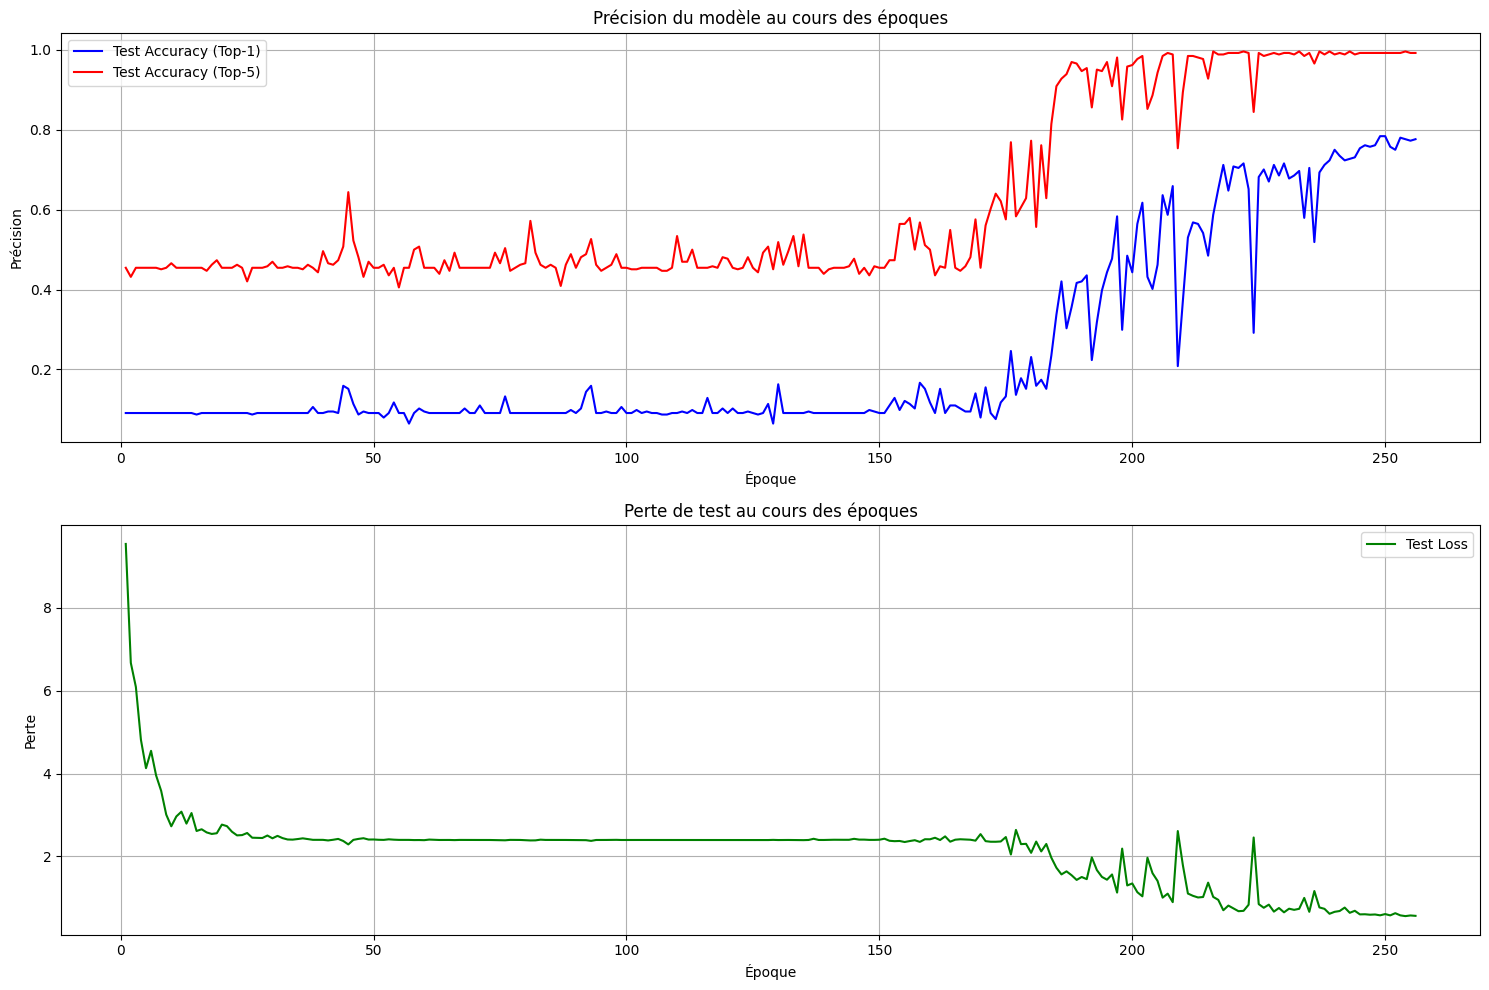

Meilleure précision: 0.7841 à l'époque 249.0


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix, top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

BEGIN_EPOCH = 0
MAX_EPOCH = 50
TOP_K = 5
max_acc, best_epoch = plot_learning_curves(Record_path, Name_suffix, TOP_K)
print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")